In [1]:
# Lesson 6 - Multi-LoRA, Predibase, Inc, CTO Travis Adair
# In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

# Import required packages
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Let's create a new model
# We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

# Using a loop
# Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: 
#    batch_index --> lora_index.

class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])
torch.manual_seed(42)
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return [detokenizer[token_id] for token_id in next_token_ids]

model = LoopMultiLoraModel()



['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']
1 0.00013169193267822265
2 0.00019229936599731446
3 0.00018764972686767577
4 0.00017675352096557616
5 0.00018033599853515625
6 0.0002057008743286133
7 0.00022684669494628908
8 0.00024732017517089844
9 0.00023800134658813477
10 0.0002752518653869629
11 0.00026858663558959963
12 0.0003052644729614258
13 0.00029757022857666013
14 0.0003423218727111816
15 0.0004243812561035156
16 0.00046718883514404295
17 0.0005915446281433105
18 0.0003826603889465332
19 0.0005912165641784668
20 0.0004712257385253906
21 0.000570138931274414
22 0.0004586539268493652
23 0.0004470772743225098
24 0.00045723581314086915
25 0.0005877461433410645
26 0.0005215477943420411
27 0.0005132956504821778
28 0.0005227904319763184
29 0.0005328545570373536
30 0.000579089641571045
31 0.0005715365409851074
32 0.0005786027908325195
33 0.0007189188003540039
34 0.0006040091514587403
35 0.0008153595924377441
36 0.000895617961

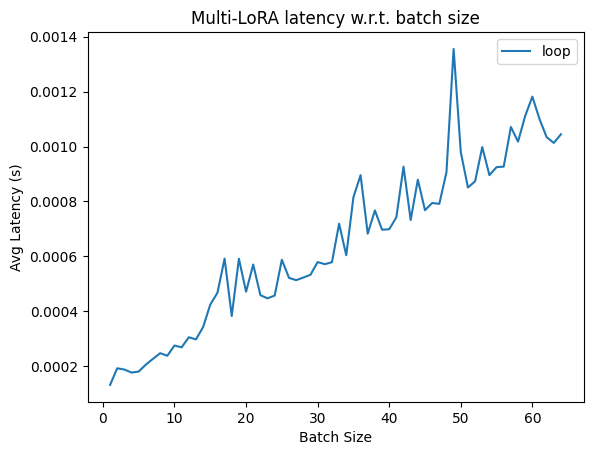

1 0.00029963254928588867
2 0.0001226963996887207
3 0.00013103199005126952
4 0.00012354135513305663
5 0.00013715457916259766
6 0.00013042497634887696
7 0.00014932584762573242
8 0.00013998937606811524
9 0.0001355886459350586
10 0.00014022111892700195
11 0.0001539912223815918
12 0.00014150238037109375
13 0.00015170955657958985
14 0.00015097856521606445
15 0.00022653865814208985
16 0.00015758562088012695
17 0.0001650357246398926
18 0.0001636209487915039
19 0.00016896533966064453
20 0.0001580977439880371
21 0.00016577863693237305
22 0.00017644166946411132
23 0.0002939586639404297
24 0.00022298479080200194
25 0.0003045811653137207
26 0.0002496476173400879
27 0.0002377619743347168
28 0.00019441270828247071
29 0.0002132110595703125
30 0.0002478528022766113
31 0.00018497228622436524
32 0.00019486284255981444
33 0.00019447851181030273
34 0.00019927406311035157
35 0.0001934518814086914
36 0.00019769668579101564
37 0.00021561050415039063
38 0.00020140600204467774
39 0.00021082639694213867
40 0.000

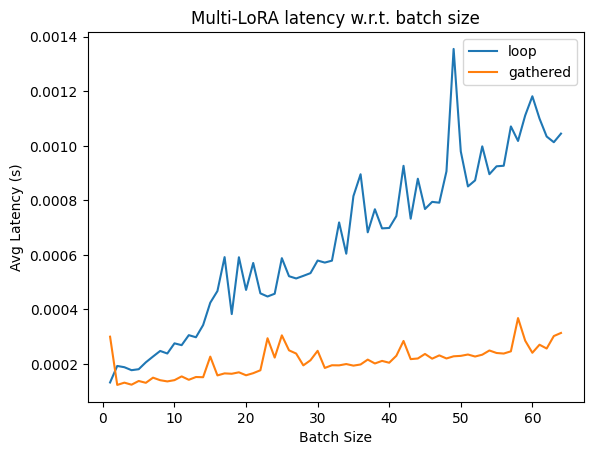

In [3]:
# Let's try it!
# We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

# Let's benchmark our multi-LoRA system!
# We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

# Note: Your results might differ from those shown in the video, but they will still follow the same pattern.

avg_latencies_loop = benchmark(model)

# Let's visualize it!
# Note: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

# Let's vectorize the LoRA computation
# We will vectorize the LoRA computation by:

# Gather the LoRA weight for each batch into a single tensor using torch.index_select.
# Apply LoRA computation once for the entire input tensor.
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y
model = GatheredMultiLoraModel()
# Note: Your results might differ from those shown in the video, but they will still follow the same pattern.

avg_latencies_gathered = benchmark(model)

# Let's visualize it!
# Note: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()